In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import pyreadstat
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pickle
import DCM

In [19]:
# Clean the risky choice data

df_raw,raw_attr = pyreadstat.read_dta('../preference survey module/data/MainSample_Replication.dta')

# Recover answers to each question
# 1 - choosing lottery (A) -> higher sure payoff
# 0 - choosing sure payoff (B) -> lower sure payoff
# j: layer / order of choice question
# i: node in the current layer

j_max = 4

for j in range(j_max+1):
    for i in range(2**(j_max-j)):

        col_name = 'layer_' + str(j_max-j+1) + '_q' +str(i+1)

        conditions = [
            df_raw['v_110'].between((2*i)*2**j+1, (2*i+1)*2**j),   
            df_raw['v_110'].between((2*i+1)*2**j+1, (2*i+2)*2**j) 
        ]

        choice_labels = [0, 1]

        new_col = np.select(conditions, choice_labels, default=np.nan)
        
        df_raw = pd.concat([df_raw, pd.DataFrame({col_name: new_col})], axis=1)

# Melt the data: each row represent a choice 
df_raw = df_raw.reset_index(names='pid')

q_columns = [col for col in df_raw.columns if 'layer_' in col]

df_melted = df_raw.melt(id_vars='pid', value_vars=q_columns, 
                        var_name='q_risk', value_name='choice').dropna()

# Calculate the sure payoff for each question
def sure_pay(s):
    parts = s.strip().split('_')

    layer_number = j_max - int(parts[1]) + 1 
    q_number = int(parts[2][1:])

    return 2**(layer_number) + (q_number - 1)*2**(layer_number+1)


df_melted['x'] = df_melted['q_risk'].apply(sure_pay)*10
df_melted['layer'] = df_melted['q_risk'].apply(lambda x: x.strip().split('_')[1])

# Pivot the data
df_wide = df_melted[['pid','x','choice','layer']].pivot(index='pid', columns='layer', values=['x', 'choice'])

df_wide.columns = [f"layer_{col}_{layer}" for col, layer in df_wide.columns]
df_wide = df_wide.reset_index()

# Merge with the original levels
df_risk = pd.merge(right=df_raw[['pid','v_110']].dropna(),left=df_wide,on='pid')
print('Number of people in df_risk:',len(df_risk))

Number of people in df_risk: 394


In [22]:
# Clean the intertemporal choice data

df_psm = pd.read_stata('../preference survey module/data/MainSample_Replication.dta')

# Recover answers to each question
# 1 - choosing SS (A) -> higher LL
# 0 - choosing LL (B) -> lower LL

df_psm['v_195'] = 32 - df_psm['v_195']

j_max = 4

for j in range(j_max+1):
    for i in range(2**(j_max-j)):

        col_name = 'layer_' + str(j_max-j+1) + '_q' +str(i+1)

        conditions = [
            df_psm['v_195'].between((2*i)*2**j+1, (2*i+1)*2**j),   
            df_psm['v_195'].between((2*i+1)*2**j+1, (2*i+2)*2**j) 
        ]

        choice_labels = [0, 1]

        new_col = np.select(conditions, choice_labels, default=np.nan)
        
        df_psm = pd.concat([df_psm, pd.DataFrame({col_name: new_col})], axis=1)

# Melt the data: each row represent a choice 
df_psm = df_psm.reset_index(names='pid')

q_columns = [col for col in df_psm.columns if 'layer_' in col]

df_melted = df_psm.melt(id_vars='pid', value_vars=q_columns, 
                        var_name='q_time', value_name='choice').dropna()

# Encode the LL payoff for each question
node_encoding_reverse = {
    (1, 1): 154,  # Layer 1 (Root), Node 1
    (2, 1): 125,  # Layer 2, Node 1 (Reversed)
    (2, 2): 185,  # Layer 2, Node 2 (Reversed)
    (3, 1): 112,  # Layer 3, Node 1 (Reversed)
    (3, 2): 139,  # Layer 3, Node 2 (Reversed)
    (3, 3): 169,  # Layer 3, Node 3 (Reversed)
    (3, 4): 202,  # Layer 3, Node 4 (Reversed)
    (4, 1): 106,  # Layer 4, Node 1 (Reversed)
    (4, 2): 119,  # Layer 4, Node 2 (Reversed)
    (4, 3): 132,  # Layer 4, Node 3 (Reversed)
    (4, 4): 146,  # Layer 4, Node 4 (Reversed)
    (4, 5): 161,  # Layer 4, Node 5 (Reversed)
    (4, 6): 177,  # Layer 4, Node 6 (Reversed)
    (4, 7): 193,  # Layer 4, Node 7 (Reversed)
    (4, 8): 210,  # Layer 4, Node 8 (Reversed)
    (5, 1): 103,  # Layer 5, Node 1 (Reversed)
    (5, 2): 109,  # Layer 5, Node 2 (Reversed)
    (5, 3): 116,  # Layer 5, Node 3 (Reversed)
    (5, 4): 129,  # Layer 5, Node 4 (Reversed)
    (5, 5): 122,  # Layer 5, Node 5 (Reversed)
    (5, 6): 136,  # Layer 5, Node 6 (Reversed)
    (5, 7): 143,  # Layer 5, Node 7 (Reversed)
    (5, 8): 150,  # Layer 5, Node 8 (Reversed)
    (5, 9): 158,  # Layer 5, Node 9 (Reversed)
    (5, 10): 165, # Layer 5, Node 10 (Reversed)
    (5, 11): 173, # Layer 5, Node 11 (Reversed)
    (5, 12): 181, # Layer 5, Node 12 (Reversed)
    (5, 13): 189, # Layer 5, Node 13 (Reversed)
    (5, 14): 197, # Layer 5, Node 14 (Reversed)
    (5, 15): 206, # Layer 5, Node 15 (Reversed)
    (5, 16): 215  # Layer 5, Node 16 (Reversed)
}

def LL_pay(s):
    parts = s.strip().split('_')

    layer_number = int(parts[1])
    q_number = int(parts[2][1:])

    return node_encoding_reverse.get((layer_number, q_number), "Node not found")


df_melted['x'] = df_melted['q_time'].apply(LL_pay)
df_melted['layer'] = df_melted['q_time'].apply(lambda x: x.strip().split('_')[1])

# Pivot the data
df_wide = df_melted[['pid','x','choice','layer']].pivot(index='pid', columns='layer', values=['x', 'choice'])

df_wide.columns = [f"layer_{col}_{layer}" for col, layer in df_wide.columns]
df_wide = df_wide.reset_index()

# Merge with the original levels
df_time = pd.merge(right=df_psm[['pid','v_195']].dropna(),left=df_wide,on='pid')
print('Number of people in df_time:', len(df_time))

Number of people in df_time: 353


In [26]:
# Test preference heterogeneity for risky choices
tab_count = df_raw['v_110'].value_counts()
tab_count.index = tab_count.index.astype(int).astype(str)

result_prop_test = DCM.prop_test(tab_count,hide=True)
prop_test_sort = sorted(result_prop_test[['p_lo_hi']].values.flatten(),reverse= True)
result_prop_test.to_csv('prop_result_risk.csv')

pvalue = min(np.array(prop_test_sort) * np.arange(1,len(prop_test_sort)+1))

print('p-value:',pvalue) 
print(result_prop_test)

p-value: 0.12319997434985816
      n   prop_lo    prop_0   prop_hi   p_lo_hi  layer  group
0    72  0.566667  0.583333  0.595238  0.499084      3      1
1    87  0.465116  0.459770  0.454545  0.623165      3      2
2    85  0.770833  0.705882  0.621622  0.958586      3      3
3    69  0.480000  0.289855  0.181818  0.997971      3      4
4    52  0.227273  0.326923  0.400000  0.155697      3      5
5     9  1.000000  0.444444  0.375000  1.000000      3      6
6    13  0.333333  0.153846  0.000000  1.000000      3      7
7   159  0.583333  0.540881  0.505747  0.872307      2      1
8   154  0.435294  0.525974  0.637681  0.009477      2      2
9    61  0.576923  0.622951  0.888889  0.074260      2      3
10  313  0.547170  0.498403  0.448052  0.969095      1      1
11   81  0.147541  0.197531  0.350000  0.053578      1      2
12  394  0.492013  0.441624  0.246914  0.999986      0      1


In [28]:
# Test preference heterogeneity for intertemporal choices
tab_count = df_time['v_195'].value_counts()
tab_count.index = tab_count.index.astype(int).astype(str)

result_prop_test = DCM.prop_test(tab_count,hide=True)
prop_test_sort = sorted(result_prop_test[['p_lo_hi']].values.flatten(),reverse= True)

result_prop_test.to_csv('prop_result_time.csv')

pvalue = min(np.array(prop_test_sort) * np.arange(1,len(prop_test_sort)+1))
print('p-value:',pvalue) 
print(result_prop_test)

p-value: 0.017705570219180032
      n   prop_lo    prop_0   prop_hi   p_lo_hi  layer  group
0    34  0.428571  0.794118  0.888889  0.020436      3      1
1    35  0.526316  0.371429  0.187500  0.993292      3      2
2    28  0.375000  0.428571  0.450000  0.527536      3      3
3    24  0.642857  0.416667  0.100000  0.999490      3      4
4    44  0.357143  0.386364  0.400000  0.527781      3      5
5    48  0.500000  0.458333  0.423077  0.794790      3      6
6    78  0.425000  0.551282  0.684211  0.018707      3      7
7    69  0.794118  0.623188  0.457143  0.999276      2      1
8    52  0.714286  0.576923  0.416667  0.993117      2      2
9    92  0.681818  0.608696  0.541667  0.944460      2      3
10  121  0.507246  0.487603  0.461538  0.752136      1      1
11  232  0.521739  0.474138  0.442857  0.905157      1      2
12  353  0.429752  0.543909  0.603448  0.001362      0      1


In [23]:
raw_attr.column_names_to_labels

{'v_150': 'Time: willingness to wait',
 'v_151': 'Time: willingness to wait compared to others',
 'v_152': 'Time: willingness to wait assessed by others',
 'v_153': 'Time: willingness to wrt financial decisions',
 'v_154': 'Time: willingness to wait wrt important life decisions',
 'v_155': 'Time: willingness to wait wrt career',
 'v_156': 'Time: willingness to wait wrt big purchases',
 'v_157': 'Time: willingness to wait wrt bigger vacation',
 'v_158': 'Time: I make decisions I later regret.',
 'v_159': 'Time: I often think about the future.',
 'v_160': 'Time: It is hard to abstain from unhealthy tasty food.',
 'v_161': 'Time: Dont care about tomorrow, only today matters',
 'v_162': 'Time: I often regret decisions that I make',
 'v_163': 'Time: I often act hastily',
 'v_164': 'Time: I save for retirement',
 'v_165': 'Time: I dont find it hard to resist temptation',
 'v_166': 'Time: I spend too much money.',
 'v_167': 'Time: I eat too much.',
 'v_168': 'Time: I dont work out enough.',
 

In [74]:
# Model estimation for risky choices
x_cols = [col for col in df_risk.columns if 'layer_x' in col]
choice_cols = [col for col in df_risk.columns if 'layer_choice' in col]
bounds = [(0,1),(0,None)]

model = DCM.mixedDiscrete(data=df_risk,
                choice = choice_cols,
                x1 = 300,
                x2 = x_cols,
                p1 = 0.5)

model.set_init_param(param_keys=['riskCoef','temp'],param_init=[0.5,1])
model.fit_param(bounds=bounds)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1299509.7691845326
        x: [ 4.530e-01  5.281e+00]
      nit: 17
      jac: [ 3.492e-01 -4.657e-02]
     nfev: 57
     njev: 19
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [78]:
DCM.get_best_result(model,bounds,n_class=2,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1252.2549555665225)

In [75]:
DCM.get_best_result(model,bounds,n_class=3,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1222.1584362371545)

In [76]:
DCM.get_best_result(model,bounds,n_class=4,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1227.2646615402546)

In [77]:
DCM.get_best_result(model,bounds,n_class=5,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1247.0369200812545)

In [88]:
bounds = [(0,1)]

model = DCM.mixedDiscrete(data=df_risk,
                choice = choice_cols,
                x1 = 300,
                x2 = x_cols,
                p1 = 0.5,
                fixed_args= {'temp':5.0})


model.set_init_param(param_keys=['riskCoef'],param_init=[0.5])
model.fit_param(bounds=bounds)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1299560.866073488
        x: [ 4.444e-01]
      nit: 6
      jac: [-5.588e-01]
     nfev: 18
     njev: 9
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [90]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=2, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1286.0407116919391, 1301.608401133968
Step 2: 2.422222222222222
Evaluation metrics: 1314.2791625266716, 1288.7637643284186
Step 3: 2.0518518518518514
Evaluation metrics: 1287.0186406004511, 1287.417730311819
Step 4: 1.804938271604938
Evaluation metrics: 1284.7301998817297, 1285.3906703963708
Step 5: 1.9695473251028806
Evaluation metrics: 1300.7385022442543, 1284.463287952449
Step 6: 1.8598079561042522
Evaluation metrics: 1284.9674466281767, 1286.5960501021784
Step 7: 1.9329675354366709
Evaluation metrics: 1293.7364887256256, 1285.8327912033933
Step 8: 1.8841944825483918
Evaluation metrics: 1284.3863582160939, 1286.1910103047644
Step 9: 1.8516791139562057
Evaluation metrics: 1291.2798433017051, 1296.623669602958
Step 10: 1.8733560263509963
Evaluation metrics: 1288.7814618102486, 1287.921594079374


({'temp': 1.8733560263509963}, np.float64(1286.4671411919994))

In [91]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=3, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1311.2352446924617, 1326.1786161006858
Step 2: 1.3111111111111113
Evaluation metrics: 1313.0048073041337, 1319.0228577046691
Step 3: 1.6814814814814816
Evaluation metrics: 1329.3708883194713, 1309.3150190414394
Step 4: 1.9283950617283954
Evaluation metrics: 1315.37936125724, 1306.9283524676996
Step 5: 2.0930041152263374
Evaluation metrics: 1320.6056387232368, 1308.5894679941987
Step 6: 1.9832647462277093
Evaluation metrics: 1309.3696473453954, 1319.3959715602664
Step 7: 1.9101051668952904
Evaluation metrics: 1327.7535616024622, 1330.725129588638
Step 8: 1.9588782197835695
Evaluation metrics: 1318.171726566253, 1316.0577026444046
Step 9: 1.9263628511913833
Evaluation metrics: 1310.6118839109497, 1336.1716333887305
Step 10: 1.9046859387965926
Evaluation metrics: 1313.9181856845914, 1316.7301514036942


({'temp': 1.9046859387965926}, np.float64(1308.151358631015))

In [92]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=4, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1342.1766001884664, 1369.7135830153493
Step 2: 1.3111111111111113
Evaluation metrics: 1344.5726389044771, 1361.0047632867218
Step 3: 1.6814814814814816
Evaluation metrics: 1360.5925287638715, 1340.2571121929843
Step 4: 1.9283950617283954
Evaluation metrics: 1346.301848474488, 1345.129507385597
Step 5: 2.0930041152263374
Evaluation metrics: 1343.9236734883455, 1339.8599759516778
Step 6: 1.9832647462277093
Evaluation metrics: 1345.857255744374, 1347.4670071270043
Step 7: 2.056424325560128
Evaluation metrics: 1346.6830400477431, 1344.575927642972
Step 8: 2.0076512726718487
Evaluation metrics: 1349.0779058228054, 1350.9163419948227
Step 9: 2.040166641264035
Evaluation metrics: 1344.7990315793645, 1342.7933889968303
Step 10: 2.061843553658826
Evaluation metrics: 1348.4528766257888, 1346.56014684255


({'temp': 2.061843553658826}, np.float64(1351.6264084238082))

In [93]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=5, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1400.5383625482416, 1403.8198610861214
Step 2: 2.422222222222222
Evaluation metrics: 1402.9570490153073, 1386.4803018838606
Step 3: 2.0518518518518514
Evaluation metrics: 1383.3287832791268, 1391.842318208449
Step 4: 1.804938271604938
Evaluation metrics: 1387.3752484214483, 1396.660096697297
Step 5: 1.6403292181069955
Evaluation metrics: 1385.7498341066391, 1386.415041597943
Step 6: 1.5305898491083674
Evaluation metrics: 1381.9658475665005, 1385.5965348723137
Step 7: 1.603749428440786
Evaluation metrics: 1382.925121632903, 1382.5131445911932
Step 8: 1.6525224813290653
Evaluation metrics: 1385.7398059887942, 1380.4973979094195
Step 9: 1.6200071127368791
Evaluation metrics: 1380.490396723678, 1402.8838724135771
Step 10: 1.64168402513167
Evaluation metrics: 1396.0554922004642, 1381.6611832964115


({'temp': 1.64168402513167}, np.float64(1391.6238856936186))

In [94]:
# Model estimation for intertemporal choices
x_cols = [col for col in df_time.columns if 'layer_x' in col]
choice_cols = [col for col in df_time.columns if 'layer_choice' in col]
bounds = [(0,1),(0,None)]

model = DCM.mixedDiscrete(data=df_time,
                choice = choice_cols,
                x1 = 100,
                x2 = x_cols,
                t2 = 1,
                fixed_args= {'riskCoef':.453}
                )

model.set_init_param(param_keys=['delta','temp'],param_init=[0.5,1.0])
model.fit_param()

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1215171.795226053
        x: [ 7.264e-01  5.111e+00]
      nit: 20
      jac: [-3.097e+00 -4.657e-02]
     nfev: 66
     njev: 22
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [95]:
DCM.get_best_result(model,bounds,n_class=2,n_init_point=8,name_prefix='models_psm/time',name_suffix='2param')

np.float64(1231.0502614577665)

In [96]:
DCM.get_best_result(model,bounds,n_class=3,n_init_point=8,name_prefix='models_psm/time',name_suffix='2param')

np.float64(1252.948258869402)

In [97]:
DCM.get_best_result(model,bounds,n_class=4,n_init_point=8,name_prefix='models_psm/time',name_suffix='2param')

np.float64(1278.752364146803)

In [98]:
DCM.get_best_result(model,bounds,n_class=5,n_init_point=8,name_prefix='models_psm/time',name_suffix='2param')

np.float64(1307.4473895365725)

In [101]:
# Treat temp as a fixed argument  
bounds = [(0,1)]

model = DCM.mixedDiscrete(data=df_time,
                choice = choice_cols,
                x1 = 100,
                x2 = x_cols,
                t2 = 1,
                fixed_args= {'riskCoef':.453,'temp': 5.0}
                )

model.set_init_param(param_keys=['delta'],param_init=[0.5])
model.fit_param()

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1215173.716033179
        x: [ 7.280e-01]
      nit: 4
      jac: [ 6.985e-02]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [102]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=2, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1185.9703677170887, 1231.915379756782
Step 2: 1.3111111111111113
Evaluation metrics: 1150.21680758793, 1211.2940924514414
Step 3: 0.9407407407407408
Evaluation metrics: 1111.4746115241373, 1175.1256363499417
Step 4: 0.6938271604938272
Evaluation metrics: 1079.7620459832945, 1138.627380344303
Step 5: 0.5292181069958848
Evaluation metrics: 1061.0412594854624, 1101.2469259259944
Step 6: 0.41947873799725655
Evaluation metrics: 1057.6985650256768, 1072.753530485322
Step 7: 0.49263831732967533
Evaluation metrics: 1067.0487737102378, 1058.518672876163
Step 8: 0.4438652644413961
Evaluation metrics: 1057.1639490442512, 1062.0896206242603
Step 9: 0.47638063303358225
Evaluation metrics: 1058.1050904518277, 1057.7679168904751
Step 10: 0.4547037206387915
Evaluation metrics: 1057.2159450604065, 1058.8244731764094


({'temp': 0.4547037206387915}, np.float64(1057.2160097371773))

In [103]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=3, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1207.1893343797003, 1253.926111421376
Step 2: 1.3111111111111113
Evaluation metrics: 1171.6476563736924, 1230.4504247942346
Step 3: 0.9407407407407408
Evaluation metrics: 1134.0166920775735, 1196.9305562957866
Step 4: 0.6938271604938272
Evaluation metrics: 1094.7805308272739, 1160.436530667801
Step 5: 0.5292181069958848
Evaluation metrics: 1038.6782043210255, 1124.0413637005058
Step 6: 0.41947873799725655
Evaluation metrics: 996.1378997993064, 1077.204687558315
Step 7: 0.34631915866483765
Evaluation metrics: 966.0613118600788, 1024.6309773792354
Step 8: 0.2975461057765585
Evaluation metrics: 951.1775842590046, 986.1735673334111
Step 9: 0.2650307371843723
Evaluation metrics: 944.0511362039473, 961.3229792014971
Step 10: 0.24335382478958154
Evaluation metrics: 941.8713714002947, 948.3912146469429


({'temp': 0.24335382478958154}, np.float64(937.7451724682197))

In [104]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=4, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1234.3322575174461, 1279.8532795464707
Step 2: 1.3111111111111113
Evaluation metrics: 1195.7067093583682, 1255.7887781223244
Step 3: 0.9407407407407408
Evaluation metrics: 1162.536781338232, 1223.0242045978157
Step 4: 0.6938271604938272
Evaluation metrics: 1120.1021231020006, 1184.0015961242345
Step 5: 0.5292181069958848
Evaluation metrics: 1069.637900707252, 1153.534242567302
Step 6: 0.41947873799725655
Evaluation metrics: 1023.9007281024275, 1105.139568789206
Step 7: 0.34631915866483765
Evaluation metrics: 1001.159020505935, 1056.3424419315388
Step 8: 0.2975461057765585
Evaluation metrics: 944.7924438686795, 1019.0200383404847
Step 9: 0.2650307371843723
Evaluation metrics: 918.2322765729242, 969.2214014165315
Step 10: 0.24335382478958154
Evaluation metrics: 899.6037674912083, 936.1234338630355


({'temp': 0.24335382478958154}, np.float64(899.6038703578048))

In [105]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=5, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1264.7853488716776, 1308.69260401869
Step 2: 1.3111111111111113
Evaluation metrics: 1223.631378656956, 1284.7604629710436
Step 3: 0.9407407407407408
Evaluation metrics: 1186.7459642672195, 1251.5949966211558
Step 4: 0.6938271604938272
Evaluation metrics: 1154.5798768288678, 1212.9682880677992
Step 5: 0.5292181069958848
Evaluation metrics: 1099.3611480304667, 1176.1968893454482
Step 6: 0.41947873799725655
Evaluation metrics: 1056.491009693846, 1139.7047336965297
Step 7: 0.34631915866483765
Evaluation metrics: 1016.257893221746, 1085.8886298813939
Step 8: 0.2975461057765585
Evaluation metrics: 983.1476602184566, 1046.4203397386143
Step 9: 0.2650307371843723
Evaluation metrics: 951.0006232731575, 1005.7827550241848
Step 10: 0.24335382478958154
Evaluation metrics: 940.81611552767, 970.0397370408612


({'temp': 0.24335382478958154}, np.float64(934.7847002856626))

(array([100.,  28.,   0.,   0.,  61.,  12.,  23.,   0.,   0.,   0.,  18.,
         18.,   5.,  14.,   0.,   3.,   0.,   0.,   0.,  71.]),
 array([0.72341304, 0.73443169, 0.74545033, 0.75646898, 0.76748763,
        0.77850627, 0.78952492, 0.80054357, 0.81156221, 0.82258086,
        0.8335995 , 0.84461815, 0.8556368 , 0.86665544, 0.87767409,
        0.88869273, 0.89971138, 0.91073003, 0.92174867, 0.93276732,
        0.94378597]),
 <BarContainer object of 20 artists>)

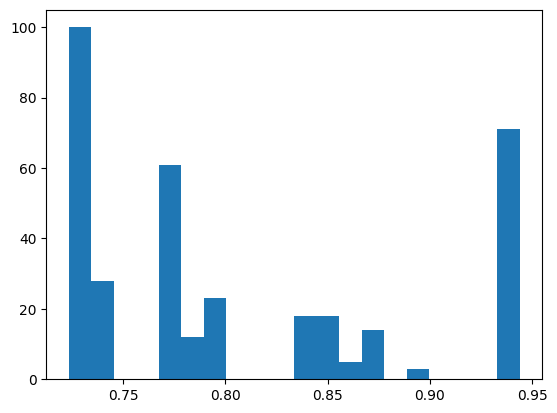

In [106]:
model = pickle.load(open(f'models_psm/time_class_4.pkl', 'rb'))

plt.hist((model.post_prob * model.latent_class['delta']).sum(axis=1),bins=20)

In [110]:
x_cols = [col for col in df_time.columns if 'layer_x' in col]
choice_cols = [col for col in df_time.columns if 'layer_choice' in col]

model = DCM.mixedNormal(data=df_time,
                choice = choice_cols,
                x1 = 100,
                x2 = x_cols,
                t2 = 1,
                fixed_args= {'riskCoef':.453}
                )

model.set_init_mixed(meta_param = {'mean':[0.1,1],'variance':[[1.0,0.1],[0.1,1.0]]}, 
                     param_keys= ['delta','temp'],
                     dist_type=['johnson_sb','lognormal'],
                     n_draws = 200,
                     n_batch = 5)

model.runEM(max_iter=100)

c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:585: RuntimeWarning: divide by zero encountered in log
  self.obj_func = - np.sum(self.w * np.log(self.likeIndiv(const))) / self.n_random


Iteration 1
{'mean': [np.float64(0.4907330668134282), np.float64(1.3545873095093177)], 'variance': array([[ 0.89641351, -0.17313165],
       [-0.17313165,  0.82482622]])}
gradient: (array([-1.33226763e-15,  1.63535852e-13]), array([[8.01166078e-12, 2.27707696e-12],
       [2.27682283e-12, 1.19510651e-12]]))
objective: inf
Iteration 2
{'mean': [np.float64(0.6402012441058539), np.float64(1.4503688702313382)], 'variance': array([[ 0.89179685, -0.26823056],
       [-0.26823056,  0.7623442 ]])}
gradient: (array([ 1.66533454e-14, -2.22044605e-16]), array([[-7.21284144e-13,  1.11736315e-12],
       [ 1.11022302e-12,  1.92223668e-12]]))
objective: 1342.294751925786
Iteration 3
{'mean': [np.float64(0.7346181638907431), np.float64(1.4949511493689407)], 'variance': array([[ 0.94047835, -0.29037324],
       [-0.29037324,  0.66720314]])}
gradient: (array([3.04201109e-14, 3.16469073e-13]), array([[-6.88560320e-13, -2.54740673e-13],
       [-2.40696352e-13, -2.31720199e-12]]))
objective: 1311.2613860

In [111]:
model.simuIndivParam(optim=True)

{'delta': array([0.72632303, 0.73506943, 0.73662615, 0.73017168, 0.72700708,
        0.73231428, 0.73462557, 0.73114621, 0.72691153, 0.73369307,
        0.73209729, 0.72769459, 0.73225627, 0.73275299, 0.73237535,
        0.73005686, 0.73185654, 0.72790844, 0.7356991 , 0.73074928,
        0.73432295, 0.72696059, 0.7341939 , 0.73121556, 0.72745869,
        0.73189573, 0.73362882, 0.72732311, 0.73614527, 0.73716748,
        0.72860791, 0.7359108 , 0.7330016 , 0.72827909, 0.72562517,
        0.72633376, 0.73606259, 0.72982893, 0.73494085, 0.73065314,
        0.73039615, 0.72694374, 0.72966433, 0.73009005, 0.73329895,
        0.73323102, 0.72865133, 0.7357137 , 0.73574042, 0.73443084,
        0.73636815, 0.73591391, 0.72743077, 0.73180059, 0.72630456,
        0.73270697, 0.73667136, 0.73698271, 0.73195879, 0.72658569,
        0.73318923, 0.73156703, 0.73265229, 0.73358294, 0.73309473,
        0.72708264, 0.73225232, 0.72817332, 0.73237505, 0.73230029,
        0.73420931, 0.7336499 , 0.72897

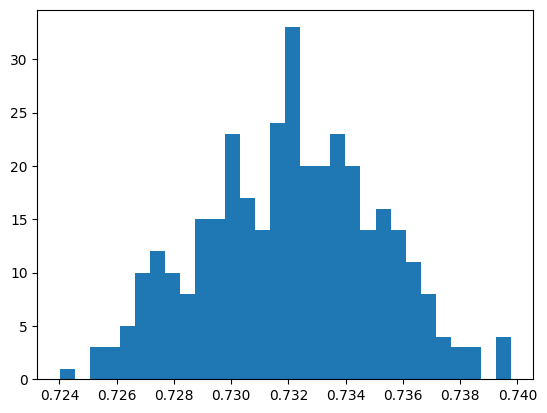

In [112]:
plt.hist(model.simu_indiv_params['delta'],bins=30)

pickle.dump(model, open(f'models_psm/time_normal.pkl', 'wb'))

In [153]:
time_col_list = [col for col in raw_attr.column_names[:8]]
df_raw_time = df_raw[df_raw['pid'].isin(df_time['pid'])]

# standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df_raw_time)

# PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_raw_time[time_col_list])

print("Explained Variance Ratio:", pca.explained_variance_ratio_)


# Correlation between riskCoef and temp in dual-parameter joint estimation
tmp_model = pickle.load(open('models_psm/time_class_2_2param.pkl', 'rb'))
tmp_delta = 1 - (tmp_model.post_prob * tmp_model.latent_class['delta']).sum(axis=1)
tmp_temp = (tmp_model.post_prob * tmp_model.latent_class['temp']).sum(axis=1)
print(st.pearsonr(tmp_delta,tmp_temp))

# Regression
model = pickle.load(open('models_psm/time_class_4.pkl', 'rb'))
df_raw_time['willing_wait'] = principal_components[:,0]
df_raw_time['delta'] = (model.post_prob * model.latent_class['delta']).sum(axis=1)

endog = df_raw_time['willing_wait']
exog = sm.add_constant(df_raw_time[['delta'] + [f'v_{i}' for i in range(158,195)]].astype(float))

reg_model = sm.OLS(endog,exog).fit()
reg_model.summary()

Explained Variance Ratio: [0.41194429 0.15928808 0.14590817]
PearsonRResult(statistic=np.float64(-1.0), pvalue=np.float64(0.0))


C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_19072\2532023668.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_time['willing_wait'] = principal_components[:,0]
C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_19072\2532023668.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_time['delta'] = (model.post_prob * model.latent_class['delta']).sum(axis=1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           willing_wait   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     9.013
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           7.09e-32
Time:                        23:05:50   Log-Likelihood:                -879.52
No. Observations:                 353   AIC:                             1837.
Df Residuals:                     314   BIC:                             1988.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7515      2.368     -2.428      0.016     -10.411      -1.092
delta         15.0869      2.208      6.833      0.000      10.743      19.431
v_158          0.0220      0.091      0.241      0.810      -0.158       0.202
v_159          0.0423      0.095      0.446      0.656      -0.144       0.229
v_160          0.0038      0.066      0.058      0.953      -0.126       0.134
v_161          0.2754      0.096      2.877      0.004       0.087       0.464
v_162          0.0021      0.104      0.021      0.984      -0.202       0.207
v_163          0.0940      0.083      1.133      0.258      -0.069       0.257
v_164         -0.0770      0.055     -1.390      0.165      -0.186       0.032
v_165         -0.1177      0.078     -1.516      0.131      -0.270       0.035
v_166         -0.1605      0.083     -1.943      0.053      -0.323       0.002
v_167          0.0651      0.071      0.921      0.358      -0.074       0.204
v_168          0.0522      0.056      0.939      0.348      -0.057       0.162
v_169         -0.1174      0.074     -1.580      0.115      -0.264       0.029
v_170         -0.2921      0.075     -3.894      0.000      -0.440      -0.145
v_171          0.0463      0.085      0.547      0.585      -0.120       0.213
v_172          0.0606      0.064      0.939      0.348      -0.066       0.187
v_173         -0.0882      0.103     -0.859      0.391      -0.290       0.114
v_174         -0.0400      0.077     -0.522      0.602      -0.191       0.111
v_175          0.0228      0.062      0.370      0.712      -0.098       0.144
v_176         -0.0010      0.063     -0.016      0.987      -0.124       0.122
v_177          0.1840      0.078      2.373      0.018       0.031       0.337
v_178         -0.0673      0.099     -0.678      0.498      -0.262       0.128
v_179         -0.0677      0.098     -0.694      0.488      -0.260       0.124
v_180         -0.0484      0.064     -0.756      0.450      -0.174       0.077
v_181          0.0221      0.059      0.378      0.706      -0.093       0.137
v_182         -0.0896      0.066     -1.351      0.178      -0.220       0.041
v_183         -0.0153      0.056     -0.273      0.785      -0.126       0.095
v_184          0.0192      0.105      0.183      0.855      -0.188       0.226
v_185          0.0554      0.124      0.448      0.654      -0.188       0.299
v_186       5.743e-07    3.3e-06      0.174      0.862   -5.93e-06    7.07e-06
v_187          0.0002      0.000      1.498      0.135   -7.07e-05       0.001
v_188         -0.1165      0.083     -1.410      0.160      -0.279       0.046
v_189         -0.6224      0.091     -6.870      0.000      -0.801      -0.444
v_190         -0.0053      0.095     -0.056      0.955      -0.192       0.181
v_191          0.0388      0.082      0.471      0.638      -0.123       0.201
v_

In [154]:
# Make regression tables for intertemporal choices
indicators = ['controls','nobs','rsquared_adj','aic']
col_name_list = [
                'b_delta','se_delta',
                ]

tab_idx_list = [
                r'discount factor $\delta$',
                '',
                'controls',
                'observations',
                r'adj.$R^2$',
                'AIC',
                ]

control_cols = [f'v_{i}' for i in range(158,195)]
exog_1 = sm.add_constant(df_raw_time[control_cols].astype(float))
exog_2 = sm.add_constant(df_raw_time['delta'].astype(float))
exog_3 = sm.add_constant(df_raw_time[['delta'] + control_cols].astype(float))

reg_model_1 = sm.OLS(endog,exog_1).fit() 
reg_model_2 = sm.OLS(endog,exog_2).fit() 
reg_model_3 = sm.OLS(endog,exog_3).fit() 

col_names = col_name_list + indicators

reg_table = pd.DataFrame({'var': col_names})

for i in range(1,4):
    _result = eval(f'reg_model_{i}')
    reg_table[f'({i})'] = reg_table['var'].apply(lambda var: DCM.fill_cell(var,_result))

reg_table = reg_table.iloc[:,1:]
reg_table.index = tab_idx_list
reg_table.loc['controls'] = ['Yes', 'No', 'Yes']

DCM.make_table(reg_table,'tables/psm_time_tab.tex')

In [160]:
risk_col_list = [f'v_{i}' for i in range(94,103)]
df_raw_risk = df_raw[df_raw['pid'].isin(df_risk['pid'])]

# PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_raw_risk[risk_col_list])

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Correlation between riskCoef and temp in dual-parameter joint estimation
tmp_model = pickle.load(open('models_psm/risk_class_3_2param.pkl', 'rb'))
tmp_riskCoef = 1 - (tmp_model.post_prob * tmp_model.latent_class['riskCoef']).sum(axis=1)
tmp_temp = (tmp_model.post_prob * tmp_model.latent_class['temp']).sum(axis=1)
print(st.pearsonr(tmp_riskCoef,tmp_temp))

# Regression
model = pickle.load(open('models_psm/risk_class_2.pkl', 'rb'))
df_raw_risk['willing_risk'] = principal_components[:,0]
df_raw_risk['riskCoef'] = 1 - (model.post_prob * model.latent_class['riskCoef']).sum(axis=1)

endog = df_raw_risk['willing_risk']

controls = df_raw_risk.iloc[:,np.where(df_raw_risk.columns == 'v_103')[0][0]:np.where(df_raw_risk.columns == 'v_119')[0][0]]
exog = sm.add_constant(df_raw_risk[['riskCoef'] + list(controls.columns)].astype(float))

reg_model = sm.OLS(endog,exog).fit()
reg_model.summary()

Explained Variance Ratio: [0.4329566  0.13639427 0.11762784]
PearsonRResult(statistic=np.float64(-0.9080367815293567), pvalue=np.float64(3.236380852630585e-150))


C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_19072\315768876.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_risk['willing_risk'] = principal_components[:,0]
C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_19072\315768876.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_risk['riskCoef'] = 1 - (model.post_prob * model.latent_class['riskCoef']).sum(axis=1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           willing_risk   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     11.64
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           1.91e-45
Time:                        23:07:10   Log-Likelihood:                -995.69
No. Observations:                 394   AIC:                             2079.
Df Residuals:                     350   BIC:                             2254.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4293      2.338     -2.322      0.021     -10.028      -0.831
riskCoef       3.4865      1.886      1.849      0.065      -0.223       7.196
v_103         -0.2973      0.101     -2.952      0.003      -0.495      -0.099
v_104         -0.1945      0.110     -1.774      0.077      -0.410       0.021
v_105          0.6457      0.103      6.256      0.000       0.443       0.849
v_106         -0.1389      0.149     -0.933      0.352      -0.432       0.154
v_107          0.0010      0.001      1.195      0.233      -0.001       0.003
v_108         -0.4463      0.377     -1.185      0.237      -1.187       0.295
v_111          0.0052      0.091      0.056      0.955      -0.174       0.185
v_120          0.0753      0.067      1.119      0.264      -0.057       0.208
v_122          0.0048      0.067      0.072      0.943      -0.126       0.136
v_123          0.0188      0.075      0.250      0.803      -0.129       0.167
v_124         -0.0596      0.101     -0.588      0.557      -0.259       0.140
v_125          0.0366      0.060      0.612      0.541      -0.081       0.154
v_126          0.0500      0.080      0.624      0.533      -0.108       0.208
v_127          0.0604      0.068      0.885      0.377      -0.074       0.195
v_128          0.1599      0.081      1.979      0.049       0.001       0.319
v_129          0.0613      0.073      0.838      0.403      -0.083       0.205
v_112          0.0807      0.061      1.326      0.186      -0.039       0.200
v_130         -0.0277      0.060     -0.460      0.646      -0.146       0.091
v_131         -0.0524      0.072     -0.729      0.466      -0.194       0.089
v_132          0.0925      0.086      1.073      0.284      -0.077       0.262
v_133         -0.0220      0.056     -0.391      0.696      -0.133       0.089
v_134          0.1311      0.081      1.627      0.105      -0.027       0.289
v_135          0.1175      0.058      2.041      0.042       0.004       0.231
v_136          0.0534      0.058      0.917      0.360      -0.061       0.168
v_137         -0.0571      0.059     -0.967      0.334      -0.173       0.059
v_138         -0.0465      0.069     -0.671      0.503      -0.183       0.090
v_139         -0.0544      0.075     -0.721      0.472      -0.203       0.094
v_140         -0.0013      0.074     -0.017      0.986      -0.147       0.144
v_141          0.0991      0.085      1.159      0.247      -0.069       0.267
v_142          0.0948      0.125      0.757      0.450      -0.151       0.341
v_143          0.0077      0.074      0.104      0.917      -0.138       0.154
v_144         -0.0546      0.091     -0.602      0.548      -0.233       0.124
v_145          0.0920      0.068      1.355      0.176      -0.041       0.225
v_146          0.0039      0.052      0.074      0.941      -0.099       0.107
v_

In [161]:
# Make regression tables for risky choices
indicators = ['controls','nobs','rsquared_adj','aic']
col_name_list = [
                'b_riskCoef','se_riskCoef',
                # 'b_temp','se_temp'
                ]

tab_idx_list = [
                r'risk aversion  $\gamma$',
                '',
                # r'noise $\lambda$',
                # '',
                'controls',
                'observations',
                r'adj.$R^2$',
                'AIC',
                ]

exog_1 = sm.add_constant(df_raw_risk[list(controls.columns)].astype(float))
exog_2 = sm.add_constant(df_raw_risk[['riskCoef']].astype(float))
exog_3 = sm.add_constant(df_raw_risk[['riskCoef'] + list(controls.columns)].astype(float))
# exog_2 = sm.add_constant(df_raw_risk[['riskCoef','temp']].astype(float))
# exog_3 = sm.add_constant(df_raw_risk[['riskCoef','temp'] + list(controls.columns)].astype(float))

reg_model_1 = sm.OLS(endog,exog_1).fit() 
reg_model_2 = sm.OLS(endog,exog_2).fit() 
reg_model_3 = sm.OLS(endog,exog_3).fit()

col_names = col_name_list + indicators

reg_table = pd.DataFrame({'var': col_names})

for i in range(1,4):
    _result = eval(f'reg_model_{i}')
    reg_table[f'({i})'] = reg_table['var'].apply(lambda var: DCM.fill_cell(var,_result))

reg_table = reg_table.iloc[:,1:]
reg_table.index = tab_idx_list
reg_table.loc['controls'] = ['Yes','No','Yes']

DCM.make_table(reg_table,'tables/psm_risk_tab.tex')

In [223]:
corr_riskCoef = df_raw_risk[['riskCoef'] + list(controls.columns)].corr().iloc[0,:].sort_values()[:-1]

labels = {key:value for key,value in raw_attr.column_names_to_labels.items() if key in corr_riskCoef.index}
labels = pd.DataFrame.from_dict(labels, orient='index').rename(columns={0:'label'})
corr_labels = pd.merge(left = corr_riskCoef, right = labels, left_index=True, right_index=True)

pd.set_option('display.max_colwidth', None)
pd.concat([corr_labels.head(), corr_labels.tail()])

,riskCoef,label
v_106,-0.155209,Risk: how much would you invest into risky lottery?
v_108,-0.087601,Risk: Willingness to switch to job with riskier payment scheme
v_140,-0.080155,"Risk: how likely: do dangerous sports, eg sky diving, mountain climbing"
v_104,-0.079036,Risk: I avoid risky things.
v_103,-0.073876,Risk: It is better to be safe than sorry.
v_142,0.115405,Risk: how likely: spend week's income in casino
v_132,0.127476,Risk: how likely: spend day's income on sport bets
v_105,0.178081,Risk: I like taking risks.
v_128,0.179960,Risk: how likely: 5% of annual income into volatile stock
v_107,0.200096,Risk: minimum safe option so that it is preferred over lottery


In [225]:
corr_delta = df_raw_time[['delta'] + [f'v_{i}' for i in range(158,195)]].corr().iloc[0,:].sort_values()[:-1]

labels = {key:value for key,value in raw_attr.column_names_to_labels.items() if key in corr_delta.index}
labels = pd.DataFrame.from_dict(labels, orient='index').rename(columns={0:'label'})
corr_labels = pd.merge(left = corr_delta, right = labels, left_index=True, right_index=True)

pd.concat([corr_labels.head(), corr_labels.tail()])

,delta,label
v_188,-0.204251,Time: I always try to have some extra money for unexpected expenses.
v_189,-0.190372,Time: I forego something today so that I can afford more tomorrow.
v_182,-0.136877,Time: I have a good idea of what to expect next year.
v_165,-0.099982,Time: I dont find it hard to resist temptation
v_184,-0.091737,"Time: Before making an important decision, I make up my mind about consequences"
v_179,0.126428,Time: I tend to procrastinate things even if it were better not to
v_190,0.133061,Time: I prefer to have fun today and dont think about tomorrow.
v_166,0.149698,Time: I spend too much money.
v_194,0.150274,Time: Would you be able to pay 1.000 Euro within 2 weeks?
v_191,0.194227,Time: My monthly expenses are often higher than I can afford.


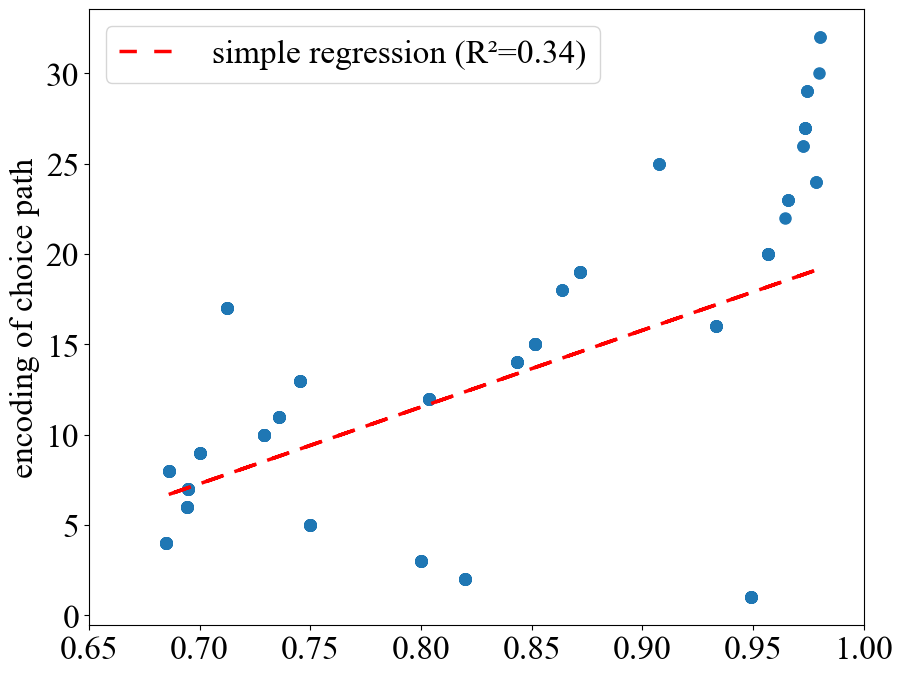

min riskCoef: 0.684689198353063
max riskCoef: 0.9799683174988327
PearsonRResult(statistic=np.float64(0.5856540791739778), pvalue=np.float64(1.20035486684949e-37))


In [190]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24

# fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ax1.scatter(df_raw_risk['riskCoef'],df_raw_risk['v_110'],s=64)
# ax1.set_xlabel('risk aversion γ')
# ax1.set_ylabel('encoding of choice path')
# ax1.set_xlim((0.3,0.9))

# ax2.scatter(df_raw_risk['temp'],df_raw_risk['v_110'],s=64)
# ax2.set_xlabel('noise λ')
# ax2.set_xlim((0,8))

# plt.legend()
# plt.show()

plt.figure(figsize=(10, 8))

plt.scatter(df_raw_risk['riskCoef'],df_raw_risk['v_110'],s=64)
# plt.xlabel('risk aversion γ')
plt.ylabel('encoding of choice path')
plt.xlim((0.65,1))

slope, intercept, r, p_value, std_err = st.linregress(x=df_raw_risk['riskCoef'], y=df_raw_risk['v_110'])
pred_subgroup = slope * df_raw_risk['riskCoef'] + intercept
plt.plot(df_raw_risk['riskCoef'], pred_subgroup, color='red', linestyle=(0,(5,5)), linewidth = 2.5, 
         label= f"simple regression (R²={r**2:.2f})")

plt.legend(loc='best')
plt.show()

print('min riskCoef:',df_raw_risk['riskCoef'].min())
print('max riskCoef:',df_raw_risk['riskCoef'].max())
print(st.pearsonr(df_raw_risk['riskCoef'],df_raw_risk['v_110']))

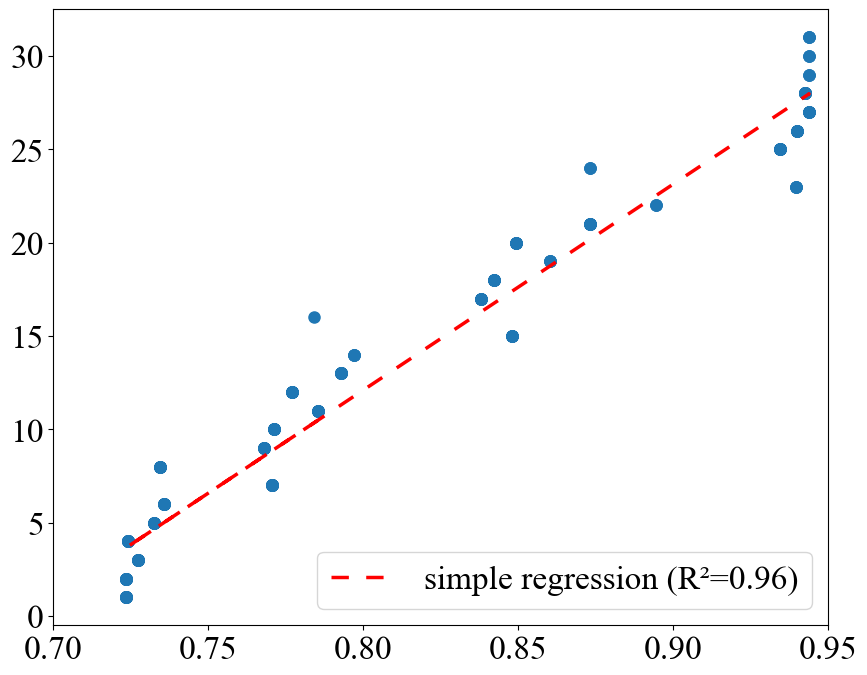

min delta: 0.7234130420744812
max delta: 0.943785965781655
PearsonRResult(statistic=np.float64(0.9819174320302432), pvalue=np.float64(8.404666360837449e-256))


In [196]:
plt.figure(figsize=(10, 8))

plt.scatter(df_raw_time['delta'],df_raw_time['v_195'],s=64)
# plt.xlabel('discount factor δ')
# plt.ylabel('encoding of choice path')
plt.xlim((0.7,0.95))

slope, intercept, r, p_value, std_err = st.linregress(x=df_raw_time['delta'], y=df_raw_time['v_195'])
pred_subgroup = slope * df_raw_time['delta'] + intercept
plt.plot(df_raw_time['delta'], pred_subgroup, color='red', linestyle=(0,(5,5)), linewidth = 2.5, 
         label= f"simple regression (R²={r**2:.2f})")

plt.legend(loc='lower right')
plt.show()

print('min delta:',df_raw_time['delta'].min())
print('max delta:',df_raw_time['delta'].max())
print(st.pearsonr(df_raw_time['delta'],df_raw_time['v_195']))